### Library loading

In [1]:
import scanpy as sc, anndata as ad, numpy as np, pandas as pd
import warnings
import yaml
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.external as sce
import scipy.sparse as sp
import statsmodels.api as sm
import scanpy as sc
import cellrank as cr
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

from sklearn_extra.cluster import KMedoids

import matplotlib.pyplot 
import scanpy.external as sce
from matplotlib.colors import TwoSlopeNorm
import warnings
warnings.filterwarnings('ignore')

from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy import stats
warnings.filterwarnings('ignore')
import scvelo as scv
import plotly.express as px
import plotly.io as pio
import itertools
import decoupler as dc
import sys
pio.renderers.default = "notebook_connected"
import random
random.seed(1)


In [2]:
homeDir = os.getenv("HOME")

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

import matplotlib.pyplot as plt
sys.path.insert(1, "./utils/")


from CleanAdata import *
from SankeyOBS import *


scanpy==1.10.1 anndata==0.10.7 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.12


In [3]:
try:
    nb_fname = ipynbname.name()
except:
    nb_fname = "".join(os.path.basename(globals()["__vsc_ipynb_file__"]).split(".")[:-1])

# Load Metacells anndata

In [4]:
n_neighb = 30
n_pcs = 5

In [5]:
CombinedAdata = sc.read_h5ad("./2_TrajectoriesAdata.h5ad")



# Cellrank

In [6]:
from cellrank.kernels import ConnectivityKernel
from cellrank.kernels import CytoTRACEKernel
from cellrank.kernels import PseudotimeKernel

#Cytotrace
adataCR = CombinedAdata.copy()

adataRaw = adataCR.copy()
adataRaw.X = adataRaw.layers["median"].copy()

adataCR.raw = adataRaw.copy()

adataCR.layers["spliced"] = adataCR.layers["median"].copy()
adataCR.layers["unspliced"] = adataCR.layers["median"].copy()
scv.pp.moments(adataCR, n_pcs=None, n_neighbors=None, use_highly_variable=False)
ctk = CytoTRACEKernel(adataCR).compute_cytotrace(use_raw=True).compute_transition_matrix(threshold_scheme="soft", nu=0.5)


computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


  0%|          | 0/3200 [00:00<?, ?cell/s]

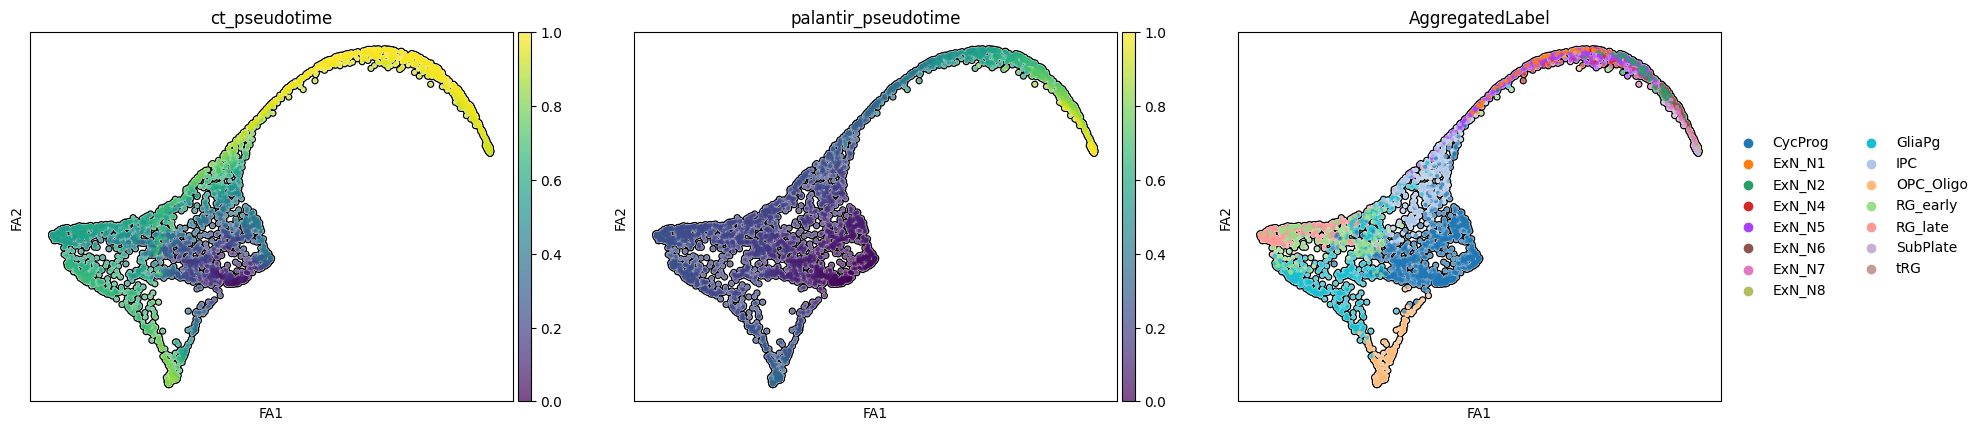

In [7]:
sc.pl.draw_graph(adataCR, color=["ct_pseudotime","palantir_pseudotime","AggregatedLabel"], add_outline=True)


In [ ]:
# connectivities
ck = ConnectivityKernel(adataCR).compute_transition_matrix()

# dpt
pk = PseudotimeKernel(adataCR, time_key="palantir_pseudotime").compute_transition_matrix()

combined_kernel = .8 * pk + .2 * ctk + .1 * ck 
combined_kernel

  0%|          | 0/3200 [00:00<?, ?cell/s]

(0.8 * PseudotimeKernel[n=3200, dnorm=False, scheme='hard', frac_to_keep=0.3] + 0.2 * CytoTRACEKernel[n=3200, dnorm=False, scheme='soft', b=10.0, nu=0.5] + 0.1 * ConnectivityKernel[n=3200, dnorm=True, key='connectivities'])

  0%|          | 0/100 [00:00<?, ?sim/s]

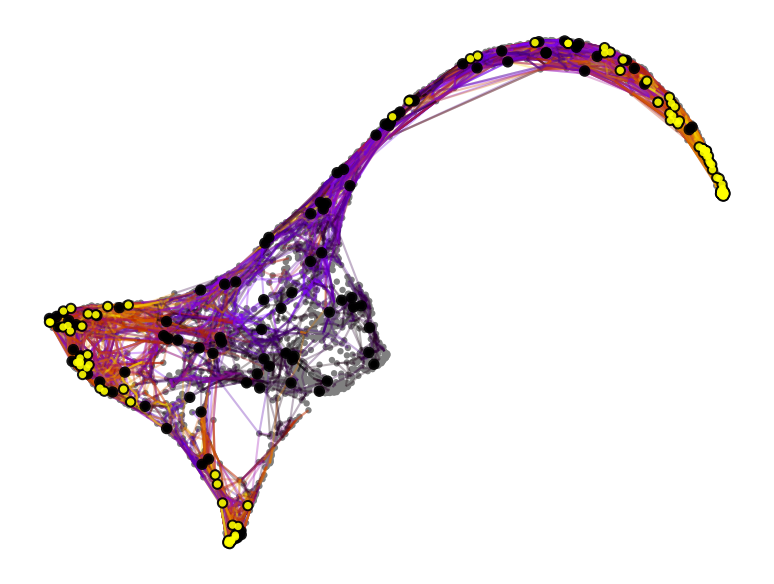

In [9]:
combined_kernel.plot_random_walks(
    seed=0,
    n_sims=100,
    basis="X_draw_graph_fa",
    legend_loc="right",
    dpi=150,
)

In [10]:
from cellrank.estimators import GPCCA

g = GPCCA(combined_kernel)
print(g)

GPCCA[kernel=(0.727 * PseudotimeKernel[n=3200] + 0.182 * CytoTRACEKernel[n=3200] + 0.091 * ConnectivityKernel[n=3200]), initial_states=None, terminal_states=None]


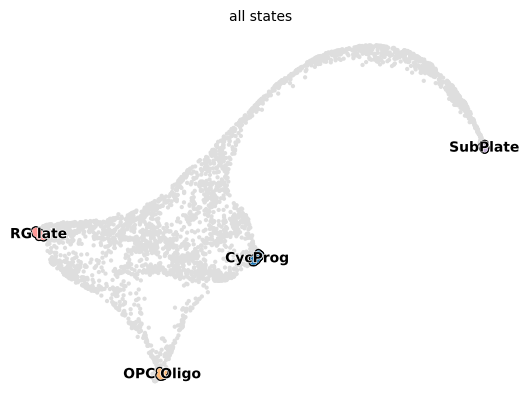

In [11]:
g.fit(n_states=4, cluster_key="AggregatedLabel")
g.plot_macrostates(which="all", basis="X_draw_graph_fa")

In [12]:
g.set_initial_states("CycProg")
g.set_terminal_states(["RG_late", "SubPlate","OPC_Oligo"])

GPCCA[kernel=(0.727 * PseudotimeKernel[n=3200] + 0.182 * CytoTRACEKernel[n=3200] + 0.091 * ConnectivityKernel[n=3200]), initial_states=['CycProg'], terminal_states=['OPC_Oligo', 'RG_late', 'SubPlate']]

In [13]:
g.compute_fate_probabilities()

  0%|          | 0/3 [00:00<?, ?/s]

[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


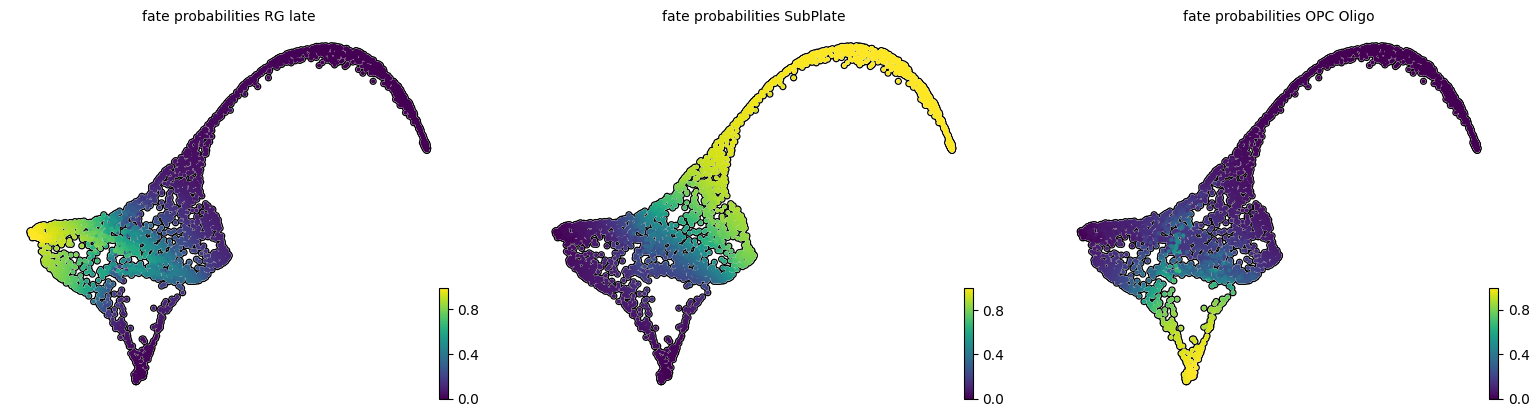

In [14]:
g.plot_fate_probabilities(basis="X_draw_graph_fa", same_plot=False, add_outline=True)

In [15]:
model = cr.models.GAMR(adataCR, n_knots=6, smoothing_penalty=10.0)


  0%|          | 0/40 [00:00<?, ?gene/s]

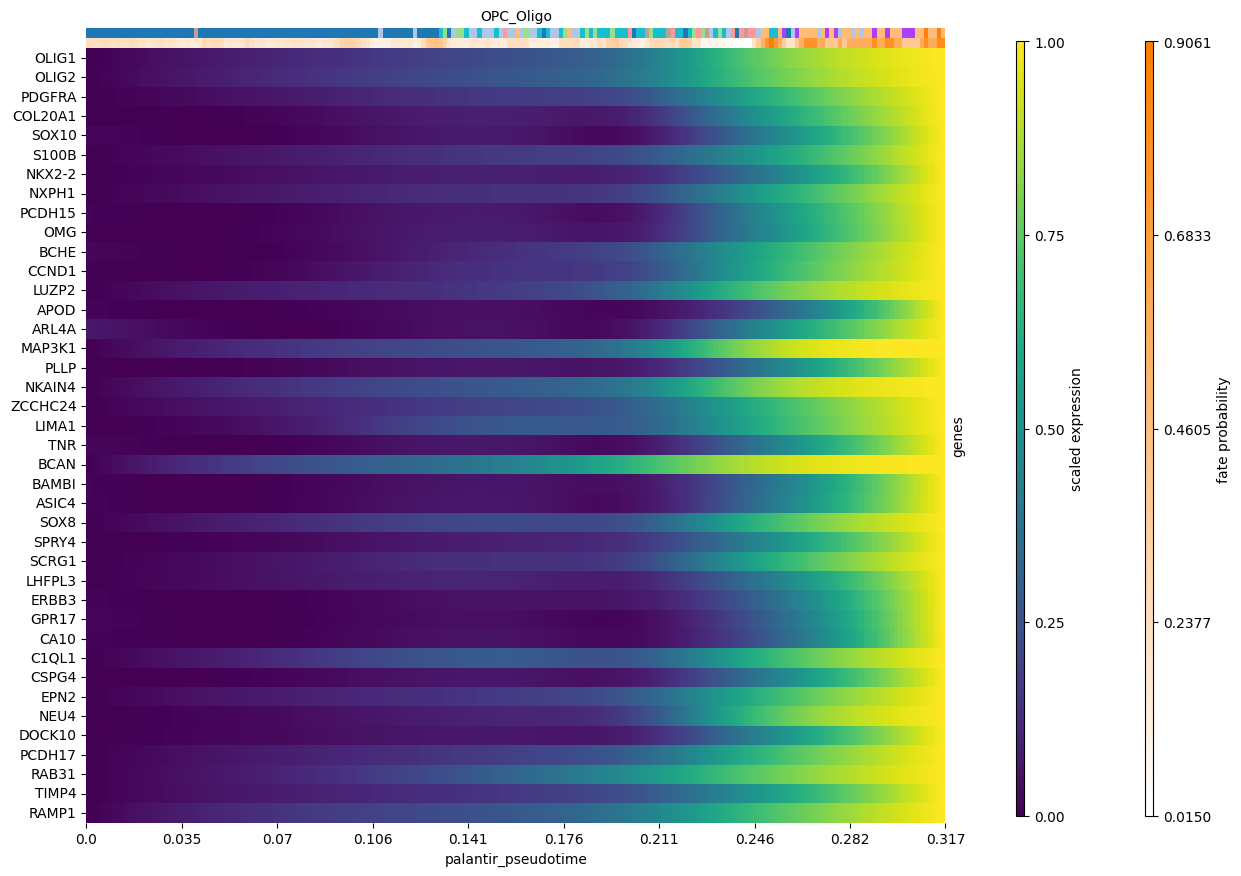

In [16]:
# compute putative drivers for the Beta trajectory
OPC_Oligo_drivers = g.compute_lineage_drivers(lineages="OPC_Oligo")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="OPC_Oligo",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=OPC_Oligo_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

  0%|          | 0/40 [00:00<?, ?gene/s]

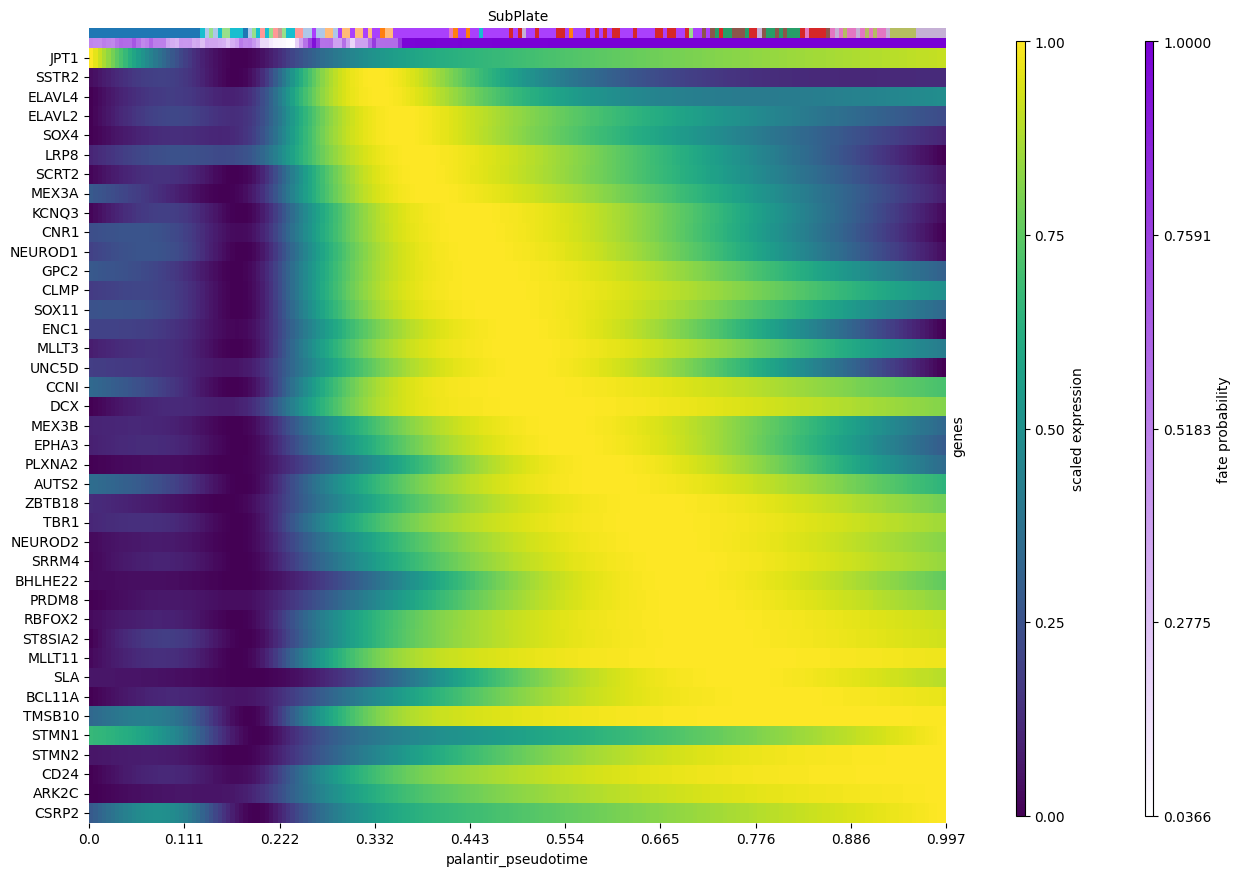

In [17]:
# compute putative drivers for the Beta trajectory
SubPlate_drivers = g.compute_lineage_drivers(lineages="SubPlate")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="SubPlate",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=SubPlate_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

  0%|          | 0/40 [00:00<?, ?gene/s]

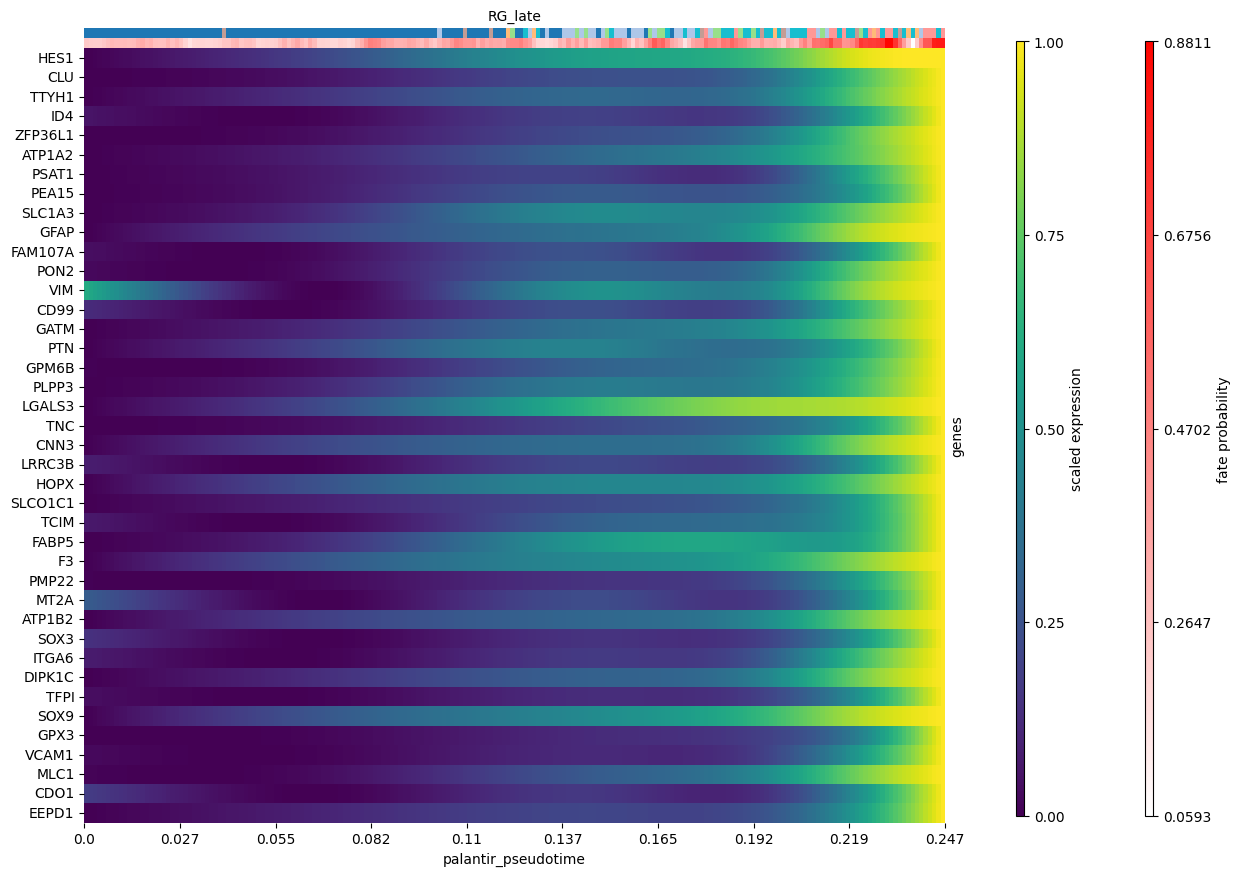

In [18]:
# compute putative drivers for the Beta trajectory
RG_late_drivers = g.compute_lineage_drivers(lineages="RG_late")

# plot heatmap
cr.pl.heatmap(
    adataCR,
    model=model,  # use the model from before
    lineages="RG_late",
    cluster_key="AggregatedLabel",
    show_fate_probabilities=True,
    data_key="MAGIC_imputed_data",
    genes=RG_late_drivers.head(40).index,
    time_key="palantir_pseudotime",
    figsize=(12, 10),
    show_all_genes=True,
    weight_threshold=(1e-3, 1e-3),
)

In [19]:
# Save the estimator
g.write("./GPCCA.pickle")

In [20]:
# Save anndata
adataCR.write_h5ad("./3_CellrankAdata.h5ad")